In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, nltk, calendar, time, gensim

sns.set()

from joblib import dump
from sklearn import metrics
from sklearn.metrics import f1_score, hamming_loss, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Import the cleaned excel file to a dataframe through pandas
path = "/Users/suhas.kamuni/Downloads/January_Reviews.xlsx"
df = pd.read_excel(path)

# Percentage of easyfeedback reviews in the data set
print(round((len(df.loc[df['Source'] == 'EasyFeedback'])/len(df))*100,2),"%")

51.67 %


In [3]:
df['Platform'].value_counts()/len(df)*100

Platform
iOS        61.666667
Android    38.333333
Name: count, dtype: float64

In [4]:
df['Source'].value_counts()/len(df)*100

Source
EasyFeedback    51.666667
Data.AI         48.333333
Name: count, dtype: float64

In [5]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Review_id           60 non-null     object        
 1   Date                60 non-null     datetime64[ns]
 2   name                16 non-null     object        
 3   title               16 non-null     object        
 4   version             28 non-null     object        
 5   Reviews Content     60 non-null     object        
 6   Rating              29 non-null     float64       
 7   Platform            60 non-null     object        
 8   Converted English   60 non-null     object        
 9   Source              60 non-null     object        
 10  Week                60 non-null     int64         
 11  Month               60 non-null     object        
 12  MemberId            31 non-null     float64       
 13  Predicted Team      60 non-null     object        
 

,Review_id,Date,name,title,version,Reviews Content,Rating,Platform,Converted English,Source,Week,Month,MemberId,Predicted Team,Probability Scores
0,7041e92f-4353-4014-9688-d1379703b568,2024-01-31,NaN,NaN,24.3.1m,In der Basis Version sehr eingeschränkt. Und d...,1.0,Android,In the basic version very limited. And that al...,Data.AI,5,"January, 2024",NaN,Messenger,37.74%
1,ed91986e-7b02-4659-83a4-bbb04239f546,2024-01-28,NaN,NaN,NaN,Worst app I ever downloaded. I keep getting sp...,1.0,Android,Worst app I ever downloaded. I keep getting sp...,Data.AI,4,"January, 2025",NaN,Notification,68.41%
2,01cd80f4-48b6-4160-b66d-0198d2029fc1,2024-01-23,NaN,NaN,24.1.1m,Im Dark Mode ist das Notification Icon der App...,2.0,Android,"In Dark Mode, the notification icon of the app...",Data.AI,4,"January, 2026",NaN,Notification,57.95%
3,60aced51-249b-4437-b2c9-2d618e72b49d,2024-01-20,NaN,NaN,24.1.1m,"Could be a good app, a rival to linked in if i...",3.0,Android,"Could be a good app, a rival to linked in if i...",Data.AI,3,"January, 2027",NaN,People/Homepage,35.66%
4,269f5680-5989-4de5-9cb0-ebd2236e1121,2024-01-16,NaN,NaN,24.0.1m,Leider sehe ich kaum noch nutzen in der App.,3.0,Android,"Unfortunately, I see hardly any use in the app...",Data.AI,3,"January, 2028",NaN,General,29.97%
5,24a1a063-1418-4d30-8da8-6d11ca1175b5,2024-01-15,NaN,NaN,24.0.1m,Bringt nicht viel App. Selbst bei Kleinigkeite...,1.0,Android,Don't bring a lot of app. Even small things re...,Data.AI,3,"January, 2029",NaN,General,25.93%
6,fb912003-b8c6-4735-bfe5-136a52baad71,2024-01-15,NaN,NaN,24.0.1m,EMPFEHLUNG. .....( +15/100),3.0,Android,RECOMMENDATION.....( +15/100),Data.AI,3,"January, 2030",NaN,General,27.49%
7,a62be798-3e3a-4586-880e-bf003d807dad,2024-01-08,NaN,NaN,24.0.1m,It's ask money.. it's giving random cities wit...,1.0,Android,It's ask money.. it's giving random cities wit...,Data.AI,2,"January, 2031",NaN,General,29.32%
8,204c93d8-9b3d-420b-8b23-9b5dc487261e,2024-01-07,NaN,NaN,23.40.1m,Das social network vermisse ich nach dem letzt...,1.0,Android,I miss the social network after the last updat...,Data.AI,1,"January, 2032",NaN,People/Homepage,42.1%
9,1d87f9b3-2a50-4141-9317-a1867a164e56,2024-01-06,NaN,NaN,24.0.1m,Etwas unverständlicherweise funktioniert das Ä...,2.0,Android,"Incomprehensiblely, changing your resume doesn...",Data.AI,1,"January, 2033",NaN,General,33.12%


In [6]:
print(df['Week'].value_counts())
#df['Month'].value_counts()

Week
1    17
3    16
4    15
2    10
5     2
Name: count, dtype: int64


In [7]:
train_df = pd.read_excel('/Users/suhas.kamuni/Downloads/Merged_Training_Set.xlsx')
train_df = train_df.drop(['Platform.1'], axis = 1)
train_df.drop(train_df.loc[(train_df['Predicted Team']=='CPAY')].index, inplace=True)
#train_df = pd.read_excel('/Users/suhas.kamuni/Downloads/Training_new_Reviews.xlsx')
train_df['Predicted Team'].value_counts()/len(train_df)

Predicted Team
General                 0.373975
People/Homepage         0.096774
Design System           0.059595
Jobs                    0.054675
Ads                     0.051394
Insights                0.050847
Premium                 0.050301
Content Architecture    0.044833
Profile                 0.042646
Reference to Groups     0.038819
LinkedIn comparison     0.037179
Messenger               0.034992
Upsell                  0.032258
Notification            0.031711
Name: count, dtype: float64

In [8]:
train_df['Rating'].isnull().value_counts()

Rating
False    1829
Name: count, dtype: int64

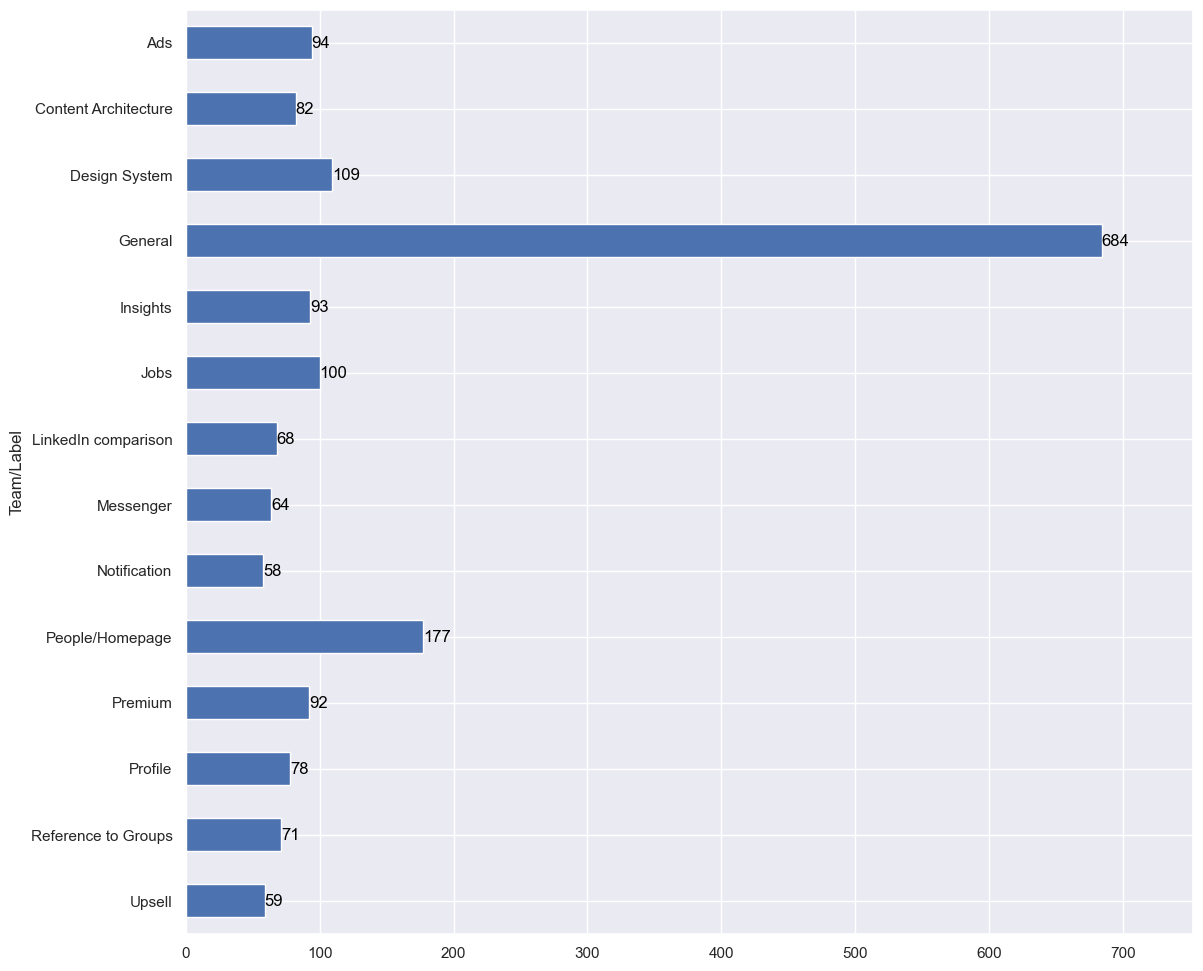

In [9]:
plt.figure(figsize = (13, 12))
train_df.rename(columns = {'Predicted Team': 'Team/Label'},inplace = True)
ax = train_df['Team/Label'].value_counts().sort_index(ascending=False).plot(kind = 'barh')

# Annotate each bar with the count
for i, v in enumerate(train_df['Team/Label'].value_counts().sort_index(ascending=False)):
    ax.text(v, i, str(v), color='black', va='center')

# To make the plot cleaner, you can add space for the labels by setting xlim
ax.set_xlim(0, max(train_df['Team/Label'].value_counts().sort_index(ascending=False))*1.1)

# Display the plot
plt.show()

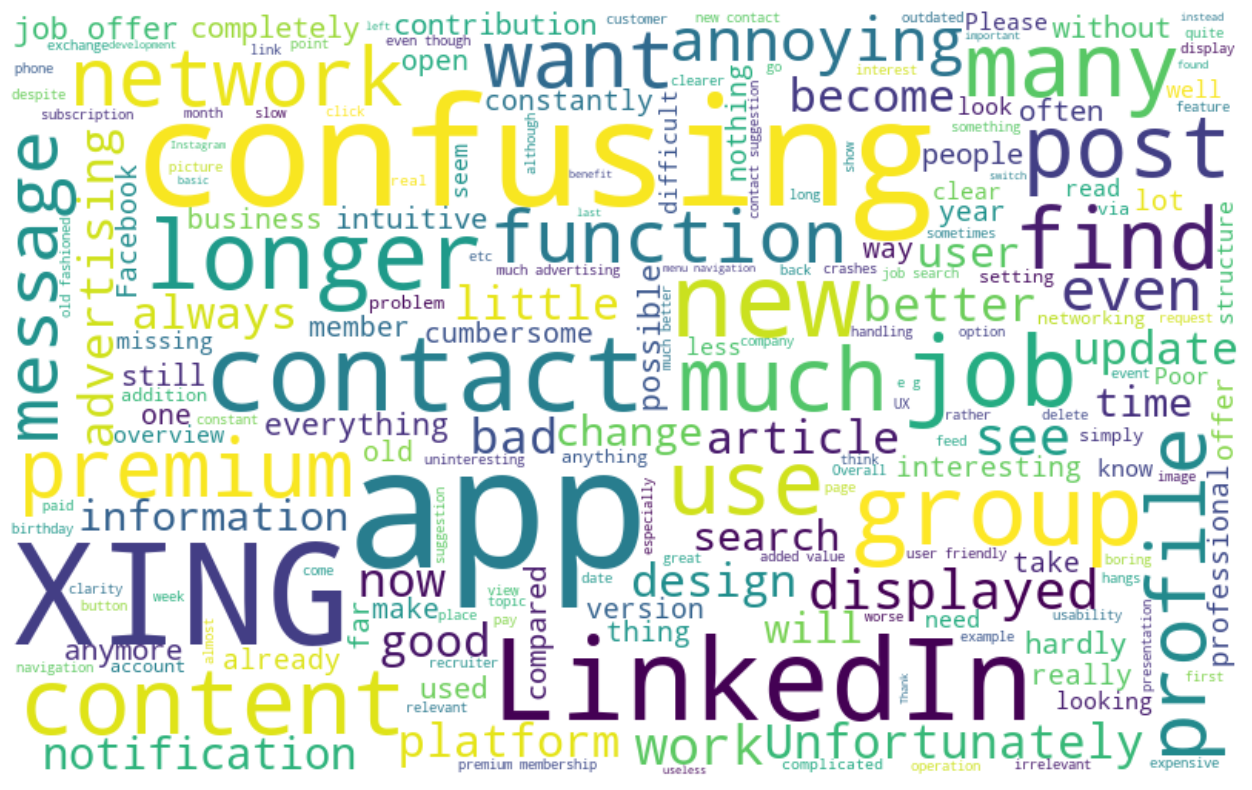

In [10]:
# this is to populate with word from the reviews
all_words = ' '.join([text for text in train_df['Converted English'].astype('str')]) 

# Import wordcloud 
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color = 'white').generate(all_words)

# Plot commands
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Let's assume 'df' is your DataFrame and it has columns 'text' and 'class_label'
# Example: df = pd.DataFrame({'text': your_text_series, 'class_label': your_label_series})

# Download NLTK stopwords if you haven't already
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Combine custom stopwords with NLTK stopwords
custom_stopwords = set(stopwords.words('english')) | ENGLISH_STOP_WORDS

# Function to tokenize and count words
def get_most_common_words(texts, num_words=10):
    tokens = word_tokenize(' '.join(texts).lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
    word_counts = Counter(filtered_tokens)
    return word_counts.most_common(num_words)

# Number of most common words to display
N = 5

plt.figure(figsize=(15, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

unique_classes = train_df['Team/Label'].unique()
class_offset = {}  # To position words of each class
offset_unit = 0.1 

"""
for class_label in unique_classes:
    texts = train_df[train_df['Team/Label'] == class_label]['Converted English']
    most_common_words = get_most_common_words(texts, N)
    
    # Unzip words and their frequencies for plotting
    words, counts = zip(*most_common_words)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    indices = np.arange(len(words))
    plt.bar(indices, counts, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Most common words in class: {class_label}')
    plt.xticks(indices, words, rotation='vertical')
    plt.show()
"""

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suhas.kamuni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suhas.kamuni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"\nfor class_label in unique_classes:\n    texts = train_df[train_df['Team/Label'] == class_label]['Converted English']\n    most_common_words = get_most_common_words(texts, N)\n    \n    # Unzip words and their frequencies for plotting\n    words, counts = zip(*most_common_words)\n    \n    # Plotting\n    plt.figure(figsize=(10, 5))\n    indices = np.arange(len(words))\n    plt.bar(indices, counts, color='skyblue')\n    plt.xlabel('Words')\n    plt.ylabel('Frequency')\n    plt.title(f'Most common words in class: {class_label}')\n    plt.xticks(indices, words, rotation='vertical')\n    plt.show()\n"

<Figure size 1500x800 with 0 Axes>

In [12]:
train_df

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Source,Month,Team/Label
0,158994127,Keine vernünftige Struktur wie bei Web Version...,Not a reasonable structure as with web version...,1,21.10.2022,NaN,Android,EasyFeedback,September,People/Homepage
1,158999921,Ich finde vorher war übersicht besser.,I think before was overview better.,2,21.10.2022,NaN,Android,EasyFeedback,September,Design System
2,159009543,Teilweise mühsame Navigation,Partly tedious navigation,3,22.10.2022,NaN,Android,EasyFeedback,September,General
3,159010950,Unpraktische Bedienung,Impractical operation,2,22.10.2022,NaN,Android,EasyFeedback,September,General
4,159033855,"Mich stört, dass laufend irgendwelche Besucher...",It bothers me that some visitors can constantl...,2,22.10.2022,NaN,Android,EasyFeedback,September,Profile
...,...,...,...,...,...,...,...,...,...,...
1861,180738858,Gesendete Kontaktanfragen sind über die App ni...,Sent contact requests cannot be accessed via t...,2,2023-09-11 00:00:00,NaN,iOS,EasyFeedback,September,People/Homepage
1862,182164129,Freundschaftsanfragen werden in der App bei mi...,Friendship requests are not displayed in the app.,2,2023-09-27 00:00:00,NaN,iOS,EasyFeedback,September,Premium
1863,181028450,Finde es in der App sehr schwer meine Kontakte...,I find it very difficult to find my contacts/n...,3,2023-09-14 00:00:00,NaN,Android,EasyFeedback,September,Profile
1864,182097301,Dazernd unpasende und bereits abgelehnte Konta...,Dazern unsuitable and already rejected contact...,2,2023-09-26 00:00:00,NaN,Android,EasyFeedback,September,Reference to Groups


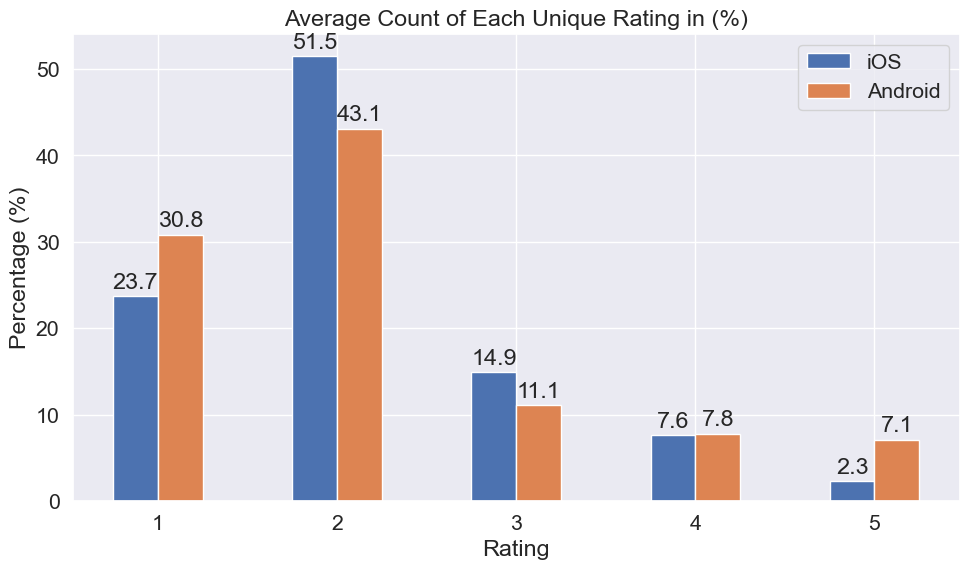

In [13]:
df = train_df
sns.set(font_scale = 1.4)
# Sample data: two lists of numbers
numbers_set1 = list(df['Rating'].loc[df.Platform == 'iOS'].astype(int))
numbers_set2 = list(df['Rating'].loc[df.Platform == 'Android'].astype(int))

# DataFrames with counts for each number
df1 = pd.DataFrame(numbers_set1, columns=['numbers']).value_counts().reset_index(name='count_set1')
df2 = pd.DataFrame(numbers_set2, columns=['numbers']).value_counts().reset_index(name='count_set2')

# Merging both DataFrames on the 'numbers' column
merged_df = pd.merge(df1, df2, on='numbers', how='outer').fillna(0).set_index('numbers').sort_index()

# Calculating the average count for each number in both sets
merged_df['avg_set1'] = round(merged_df['count_set1'] / len(numbers_set1) * 100, 1)
merged_df['avg_set2'] = round(merged_df['count_set2'] / len(numbers_set2) * 100,1)

# Create a bar plot with side-by-side comparison
labels = merged_df.index
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 6))
rects1 = ax.bar(x - width/2, merged_df['avg_set1'], width, label='iOS')
rects2 = ax.bar(x + width/2, merged_df['avg_set2'], width, label='Android')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage (%)')
ax.set_title('Average Count of Each Unique Rating in (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()

# Function to attach a text label above each bar, showing its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [14]:
def remove_pattern(input_txt, pattern):
    """ Replaces any repeating patterns in the text string """
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def clean_text(input_txt):
    input_txt = input_txt.str.replace("[^a-zA-Z#]", " ") # removes special chars
    input_txt = input_txt.str.strip() # removes white spaces
    input_txt = input_txt.str.lower() # converts to lower case
    input_txt = input_txt.fillna('') 

    p = string.punctuation
    table = str.maketrans('','',p)
    #df['data'] = df.fillna({'data':''})
    input_txt = input_txt.apply(lambda x:x.translate(table))
    input_txt = input_txt.apply(lambda x:x.split(' ')) #tokenising each word

    stopwords = set(STOPWORDS) 
    input_txt = input_txt.apply(lambda x: [word for word in x if word not in stopwords]) # removing stopwords

    ps = nltk.PorterStemmer() # stem the thing
    input_txt = input_txt.apply(lambda x: [ps.stem(word) for word in x])
    input_txt = input_txt.apply(lambda x: ' '.join([word for word in x if len(word) > 1])) # removing single letter

    input_txt = np.vectorize(remove_pattern)(input_txt, "@[\w]*")

    return input_txt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suhas.kamuni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


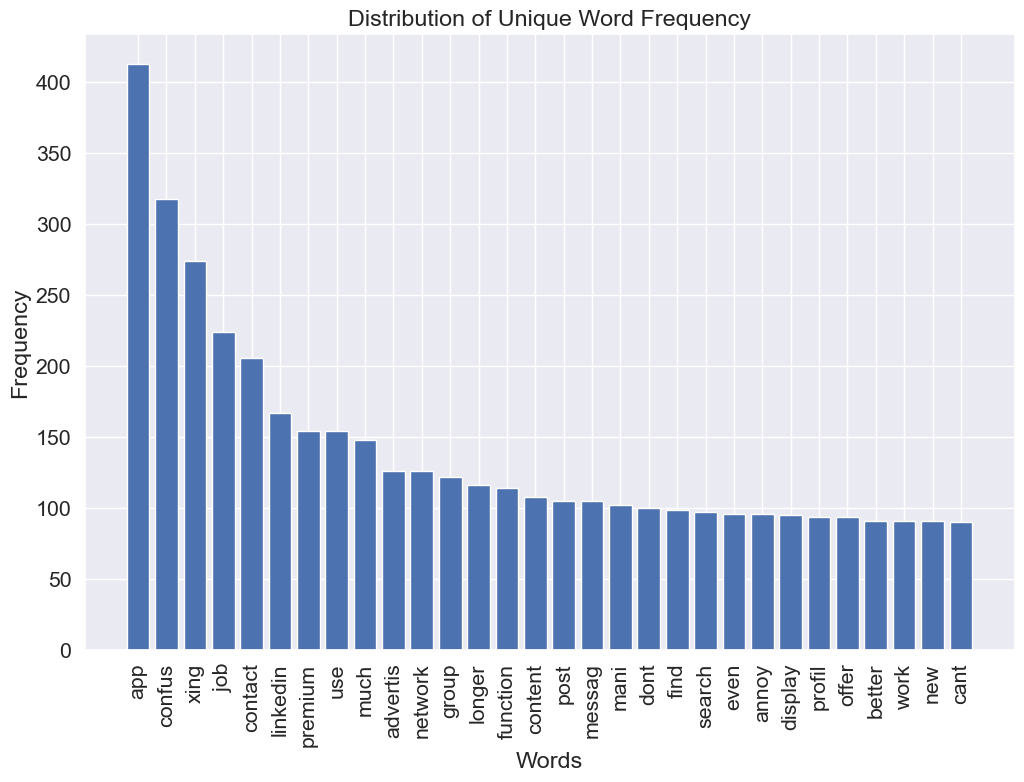

In [15]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

train_df['text_token'] = clean_text(train_df['Converted English'])

# For demonstration, create a DataFrame with a text column
# df = pd.DataFrame({'text_column': ['Your first text entry.', 'Your second text entry.', ...]})

# Assuming nltk's punkt tokenizer is not already downloaded
nltk.download('punkt')

# Tokenize each entry and get a list of words
words = train_df['text_token'].apply(word_tokenize).sum()  # Summing the lists to get a single list of words

# Creating a frequency distribution of words
fdist = FreqDist(words)

# Organize the word frequencies into a sorted list of tuples
sorted_word_frequencies = sorted(fdist.items(), key=lambda x: x[1], reverse=True)

# Separate the sorted tuples into two lists
unique_words, frequencies = zip(*sorted_word_frequencies)

# Plotting the distribution
plt.figure(figsize=(12, 8))
plt.bar(unique_words[:30], frequencies[:30])  # Only plot the top 30 words for readability
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Word Frequency')
plt.show()

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1829 entries, 0 to 1865
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review ID          1324 non-null   object
 1   Reviews Content    1829 non-null   object
 2   Converted English  1829 non-null   object
 3   Rating             1829 non-null   int64 
 4   Start Date         1829 non-null   object
 5   Version            206 non-null    object
 6   Platform           1812 non-null   object
 7   Source             1829 non-null   object
 8   Month              1829 non-null   object
 9   Team/Label         1829 non-null   object
 10  text_token         1829 non-null   object
dtypes: int64(1), object(10)
memory usage: 171.5+ KB


In [17]:
train_df.rename(columns = {'Team/Label': 'Predicted Team'}, inplace = True)
train_df.loc[train_df['Predicted Team'] == 'Ads']

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Source,Month,Predicted Team,text_token
7,159115795,"Viel zuviel Werbung, unübersichtlich, wenig we...","Far too much advertising, confusing, few valua...",1,24.10.2022,NaN,Android,EasyFeedback,September,Ads,far much advertis confus valuabl discuss hardl...
42,NaN,Zu unübersichtlich wenig informativ. XING ist ...,Too confusingly not very informative. XING is ...,2,03.09.2022,NaN,iOS,EasyFeedback,September,Ads,confusingli inform xing much better
72,NaN,Schlechte Navigation. Ungünstige Darstellung a...,Poor navigation. Unfavorable display on mobile...,1,08.09.2022,NaN,iOS,EasyFeedback,September,Ads,poor navig unfavor display mobil much advertis
106,NaN,"Es gibt immer mehr Werbung, junge Frauen verst...","There is more and more advertising, young wome...",2,13.09.2022,NaN,iOS,EasyFeedback,September,Ads,advertis young women understand portal contact...
126,NaN,"Zu viel Werbung, Pop Ups die mich nicht intere...","Too much advertising, pop-ups that don't inter...",1,16.09.2022,NaN,iOS,EasyFeedback,September,Ads,much advertis popup dont interest
...,...,...,...,...,...,...,...,...,...,...,...
1717,171929689,"Die Popups stören beim Öffnen der App, ich bez...","The pop-ups interfere with opening the app, I'...",2,02.05.2023 | 08:48,NaN,iOS,EasyFeedback,May,Ads,popup interfer open app im alreadi pay dont wa...
1728,172311935,"Veraltetes Design, veralteter Nachrichtenfeed,...","Outdated design, outdated news feed, too much ...",2,08.05.2023 | 01:27,NaN,iOS,EasyFeedback,May,Ads,outdat design outdat news feed much advertis f...
1733,172462290,Ständig Overlays für eine kostenpflichtige Mit...,Constantly overlays for a paid membership. Tha...,2,10.05.2023 | 08:12,NaN,iOS,EasyFeedback,May,Ads,constantli overlay paid membership that annoy
1734,172466846,Zuviel unnütze Infos und diese Flut an Stellen...,Too much useless information and this flood of...,1,10.05.2023 | 09:12,NaN,iOS,EasyFeedback,May,Ads,much useless inform flood job advertis interest


In [18]:
#################################
## Important Step, has to be 0 ##
len(train_df['Converted English']) - len(train_df['Converted English'].unique())

0

In [19]:
# find the repeated values in the same column of pandas dataframe
train_df[train_df.duplicated(['Converted English'], keep = False)]
#train_df.groupby('Converted English').filter(lambda x: len(x) > 1) # Alternatively

,Review ID,Reviews Content,Converted English,Rating,Start Date,Version,Platform,Source,Month,Predicted Team,text_token


In [20]:
# to drop duplicates
train_df = train_df.drop_duplicates(['Converted English'], keep = 'first') 

In [21]:
type(np.array(train_df['Rating']))
#df['Rating'] = df['Rating'].astype('int') 
train_df['Rating'].value_counts(sort = False)

Rating
1    475
2    891
3    252
5     71
4    140
Name: count, dtype: int64

# Clean Function

In [22]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def clean_text(input_txt):
    input_txt = input_txt.astype(str)
    input_txt = input_txt.str.replace("[^a-zA-Z#]", " ") # removes special chars
    input_txt = input_txt.str.strip() # removes white spaces
    input_txt = input_txt.str.lower() # converts to lower case
    input_txt = input_txt.fillna('') 

    p = string.punctuation
    table = str.maketrans('','',p)
    #df['data'] = df.fillna({'data':''})
    input_txt = input_txt.apply(lambda x:x.translate(table))
    input_txt = input_txt.apply(lambda x:x.split(' ')) #tokenising each word

    stopwords = set(STOPWORDS) 
    input_txt = input_txt.apply(lambda x: [word for word in x if word not in stopwords]) # removing stopwords

    ps = nltk.PorterStemmer() # stem the thing
    input_txt = input_txt.apply(lambda x: [ps.stem(word) for word in x])
    input_txt = input_txt.apply(lambda x: ' '.join([word for word in x if len(word) > 1])) # removing single letter

    input_txt = np.vectorize(remove_pattern)(input_txt, "@[\w]*")

    return input_txt

# Pipeline starts here!



In [23]:
train_df['Converted English'] = train_df['Converted English'].str.lower()

In [24]:
X = clean_text(train_df['Converted English'])
y = train_df['Predicted Team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2024, stratify = y)
X_train.shape, y_test.shape

((1463,), (366,))

In [25]:
X_train

array(['person profil avail littl dt well intern user will cancel premium subscript',
       'meanwhil total uninform', 'xing urgent need dark mode', ...,
       'gender annoy app thing articl nonsens stupid articl noth realiti advertis platform specifi opinion',
       'person like previou version year ago much better dont find version clear certainli matter tast',
       'find app confus orient web interfac'], dtype='<U582')

## Pipeline Begins

In [26]:
# TF-IDF Vectorizer
vectorizer_tfidf = TfidfVectorizer(lowercase = True, max_features = 500)
vectorizer_count = CountVectorizer(max_features = 500)

# Logistic Regression
LR_502 = LogisticRegression(C=502, solver='liblinear')
LR_1 = LogisticRegression(C=1, solver='liblinear')

# Random Forrest Classifier 
rnf = RandomForestClassifier(n_estimators=100, class_weight='balanced') 

In [27]:
X = vectorizer_count.fit_transform(clean_text(train_df['Converted English']))
X

<1829x500 sparse matrix of type '<class 'numpy.int64'>'
	with 12877 stored elements in Compressed Sparse Row format>

In [28]:
def train_classifier(X_try, y_try, clf):
    if clf == "ada_clf": clf = ada_clf
    elif clf == "LR_502": clf = LR_502
    elif clf == "LR_1": clf = LR_1
    elif clf == "rnf": clf = rnf
    elif clf == "svm": clf = SVM
    elif clf == "dtree": clf = DTree 
    elif clf == "knn5":clf = knn5
    elif clf == "kmeans" :clf = kmeans
    elif clf == "gnb" :clf = gnb
    elif clf == "xgbc" :clf = xgbc
    
    pipe = Pipeline([
            ("Vectorizer_tfidf", vectorizer_tfidf),
            #("Scaler", Scaler),
            ("",clf)
        ])
    pipe.fit(X_try, y_try)

    # Return the trained classifier
    return pipe


def pipe_try(xx_test, yy_test, model):
    #print('========================== {} ==========================\n'.format(model))
    print("\t \t \t\t \t------------------")
    print("\t \t \t \t \tF1 Score: ", round(f1_score(yy_test, model.predict(xx_test), average='macro')*100,3),"%")
    print("\t \t \t\t \tAccuracy: ", round(metrics.accuracy_score(yy_test, model.predict(xx_test))*100,3),"%")
    print("    \t \t \t \t       Hamming Loss: ", round(hamming_loss(yy_test, model.predict(xx_test)), 3))
    #print("    \t \t \t \t       ROC_AUC Score: ", round(roc_auc_score(yy_test, model.predict(xx_test))*100, 3), '%')
    print("    \t \t \t \t   Weighted F1 Score: ",round(f1_score(yy_test, model.predict(xx_test), average='weighted')*100,3),"%")
    print("    \t \t \t \t   ---------------------------")
    #print('================================= Pipeline Specifications ==================================')
    #print(model)
    #print("\n")
    #print(metrics.classification_report(yy_test, pr.predict(xx_test)))


def best_scores(m, n):
    acc = []
    for i in range(n):
        model = m.fit(X_train, y_train)
        acc.append(round(f1_score(y_test, model.predict(X_test), average='macro')*100,2))

    unique_elements = [x for i, x in enumerate(acc) if x not in acc[:i]]
    unique_elements.sort(reverse=True)
    acc = unique_elements[:5]
    for i in acc: print(i.astype(str) + '%') 
    

def best_model(model, n):
    start_time = time.time()
    acc = []
    for i in range(n):
        model = model.fit(X_train, y_train)
        acc.append(round(f1_score(y_test, model.predict(X_test), average='macro')*100,2))
        
    while n>0:
        model = model.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        if elapsed_time > 60:
            #print("$")
            acc_u = [x for i, x in enumerate(acc) if x not in acc[:i]]
            acc_u.sort(reverse=True)
            if round(f1_score(y_test, model.predict(X_test), average='macro')*100,2) == acc_u[1:2]:
                #print("^")
                break
        
        if round(f1_score(y_test, model.predict(X_test), average='macro')*100,2) == max(acc):
            #print("%")
            break

    return model        

In [29]:
p_lr = train_classifier(X_train, y_train, rnf)
pipe_try(X_test, y_test, p_lr)

	 	 		 	------------------
	 	 	 	 	F1 Score:  84.38 %
	 	 		 	Accuracy:  88.251 %
    	 	 	 	       Hamming Loss:  0.117
    	 	 	 	   Weighted F1 Score:  87.791 %
    	 	 	 	   ---------------------------


In [30]:
LR_502.get_params()

{'C': 502,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [31]:
rnf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [32]:
vectorizer_tfidf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 500,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [33]:
vectorizer_count.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 500,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [40]:
pipe_tf_rnf = Pipeline([
    ("Vectorizer_tfidf", vectorizer_tfidf),
    ("Random Forest", rnf)
])

param_grid = {
    "Vectorizer_tfidf__max_features": [500, 1000, 1500],
    "Vectorizer_tfidf__ngram_range": [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
    "Vectorizer_tfidf__stop_words": [None, 'english'],
    "Random Forest__n_estimators": [50, 100, 200],
    "Random Forest__max_depth" : [None, 10, 20, 30],
    #"Random_Forest__min_samples_split": [2, 5, 10],
}

# Initialize Grid Search
grid_search_tf = GridSearchCV(pipe_tf_rnf, param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit the Grid search
grid_search_tf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Vectorizer_tfidf',
                                        TfidfVectorizer(max_features=500)),
                                       ('Random Forest',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'Random Forest__max_depth': [None, 10, 20, 30],
                         'Random Forest__n_estimators': [50, 100, 200],
                         'Vectorizer_tfidf__max_features': [500, 1000, 1500],
                         'Vectorizer_tfidf__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3), (2, 2),
                                                           (2, 3)],
                         'Vectorizer_tfidf__stop_words': [None, 'english']})

In [41]:
# Define your pipeline
pipe_cn_rnf = Pipeline([
    ("Vectorizer_count", vectorizer_count),
    ("Random_Forest", rnf)
])

# Define your parameter grid
param_grid = {
    "Vectorizer_count__max_features": [500, 1000, 1500],
    "Vectorizer_count__ngram_range": [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
    #"Vectorizer_count__stop_words": [None, 'english'],
    #"Vectorizer_count__min_df": [1, 2, 5],
    #"Vectorizer_count__max_df": [0.5, 0.75, 1.0],
    "Random_Forest__n_estimators": [50, 100, 200, 300],
    #"Random_Forest__max_depth": [None, 10, 20, 30, 40],
    "Random_Forest__min_samples_split": [2, 5, 10],
    #"Random_Forest__min_samples_leaf": [1, 2, 4],
    #"Random_Forest__bootstrap": [True, False],
    #"Random Forest__n_estimators": [50, 100, 200],
    #"Random Forest__max_depth" : [None, 10, 20, 30],
}

# Initialize Grid Search
grid_search_cn = GridSearchCV(pipe_cn_rnf, param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit the Grid search
grid_search_cn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Vectorizer_count',
                                        CountVectorizer(max_features=500)),
                                       ('Random_Forest',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'Random_Forest__min_samples_split': [2, 5, 10],
                         'Random_Forest__n_estimators': [50, 100, 200, 300],
                         'Vectorizer_count__max_features': [500, 1000, 1500],
                         'Vectorizer_count__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3), (2, 2),
                                                           (2, 3)]})

In [42]:
pipe_try(X_test, y_test, grid_search_tf), pipe_try(X_test, y_test, grid_search_cn)

	 	 		 	------------------
	 	 	 	 	F1 Score:  84.13 %
	 	 		 	Accuracy:  87.978 %
    	 	 	 	       Hamming Loss:  0.12
    	 	 	 	   Weighted F1 Score:  87.575 %
    	 	 	 	   ---------------------------
	 	 		 	------------------
	 	 	 	 	F1 Score:  81.762 %
	 	 		 	Accuracy:  86.885 %
    	 	 	 	       Hamming Loss:  0.131
    	 	 	 	   Weighted F1 Score:  86.463 %
    	 	 	 	   ---------------------------


(None, None)

In [39]:
pipe_cn_rnf.fit(X_train, y_train)
pipe_tf_rnf.fit(X_train, y_train)
pipe_try(X_test, y_test, pipe_tf_rnf), pipe_try(X_test, y_test, pipe_cn_rnf)

	 	 		 	------------------
	 	 	 	 	F1 Score:  82.536 %
	 	 		 	Accuracy:  86.885 %
    	 	 	 	       Hamming Loss:  0.131
    	 	 	 	   Weighted F1 Score:  86.192 %
    	 	 	 	   ---------------------------
	 	 		 	------------------
	 	 	 	 	F1 Score:  79.541 %
	 	 		 	Accuracy:  84.973 %
    	 	 	 	       Hamming Loss:  0.15
    	 	 	 	   Weighted F1 Score:  84.189 %
    	 	 	 	   ---------------------------


(None, None)

In [ ]:
cross_val_score(grid_search, X_train, y_train, cv = 3, scoring = "f1_micro")

array([0.84836066, 0.8275154 , 0.85831622])

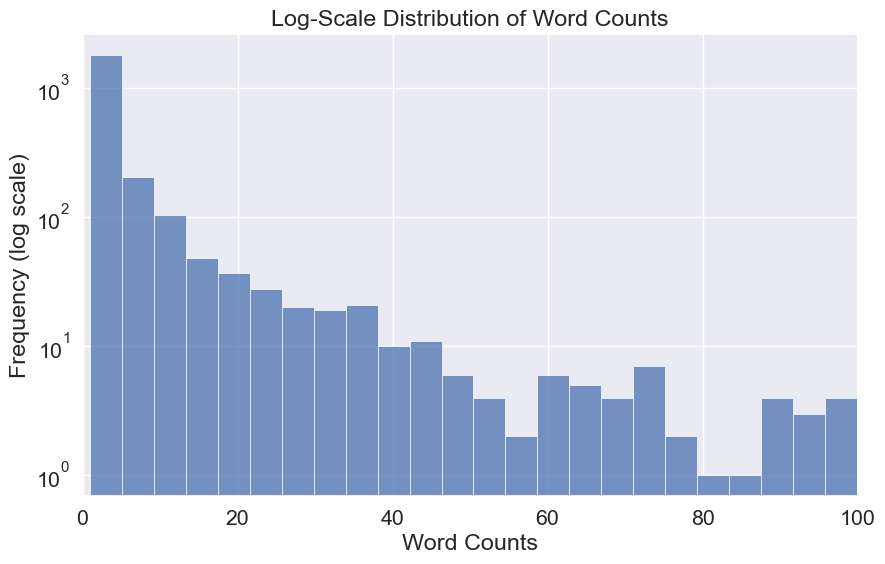

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Assume we have a DataFrame 'df' with a column 'text_column' that we want to vectorize
# df = pd.DataFrame({'text_column': ['text data 1', 'text data 2', ...]})

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data from the 'text_column'
X = vectorizer.fit_transform(clean_text(train_df['Converted English']))
# Convert the result to a dense DataFrame
word_counts_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum the occurrences of each word across all documents
word_counts = word_counts_df.sum(axis=0)

# Plot the distribution of word counts with a log scale for the frequency
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=100, kde=False, log_scale=(False,True))
plt.xlabel('Word Counts')
plt.ylabel('Frequency (log scale)')
plt.title('Log-Scale Distribution of Word Counts')
plt.xlim(0, 100)
plt.show()

In [ ]:
result_df = pd.DataFrame({'description':X_test,'true_category':y_test, 'predicted_category':grid_search.predict(X_test)})
result_df.loc[(result_df.true_category != result_df.predicted_category)].sort_index()

,description,true_category,predicted_category
36,function success compuls buy premiun version a...,Premium,General
195,bit small made everyth space display use bit t...,Design System,General
267,unfortun network possibl error messag alway ap...,People/Homepage,Messenger
381,content noth becam premium member price perfor...,Premium,Insights
554,hardli interest content interest content purch...,Insights,People/Homepage
583,birthday date alway jump next month briefli ap...,Profile,General
616,use find app much sympathet interest timelin n...,Content Architecture,Notification
633,far littl notic ad valu store mobil phone numb...,Profile,People/Homepage
685,without premium membership cant even write two...,People/Homepage,Premium
758,horribl servicei xing 2013 monthli activ user ...,People/Homepage,General


In [ ]:
result_df.loc[result_df.true_category != result_df.predicted_category].info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 267 to 583
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   description         43 non-null     object
 1   true_category       43 non-null     object
 2   predicted_category  43 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [ ]:
print(metrics.classification_report(y_test, grid_search.predict(X_test)))

                      precision    recall  f1-score   support

                 Ads       0.89      0.89      0.89        19
Content Architecture       0.87      0.81      0.84        16
       Design System       0.95      0.82      0.88        22
             General       0.90      0.99      0.94       137
            Insights       1.00      0.84      0.91        19
                Jobs       0.94      0.75      0.83        20
 LinkedIn comparison       0.74      1.00      0.85        14
           Messenger       0.72      1.00      0.84        13
        Notification       0.90      0.82      0.86        11
     People/Homepage       0.91      0.86      0.88        35
             Premium       0.78      0.78      0.78        18
             Profile       0.92      0.75      0.83        16
 Reference to Groups       0.73      0.79      0.76        14
              Upsell       1.00      0.42      0.59        12

            accuracy                           0.88       366
      

Text(0.5, 1.0, 'Confusion Matrix for Random Forrest Model\n')

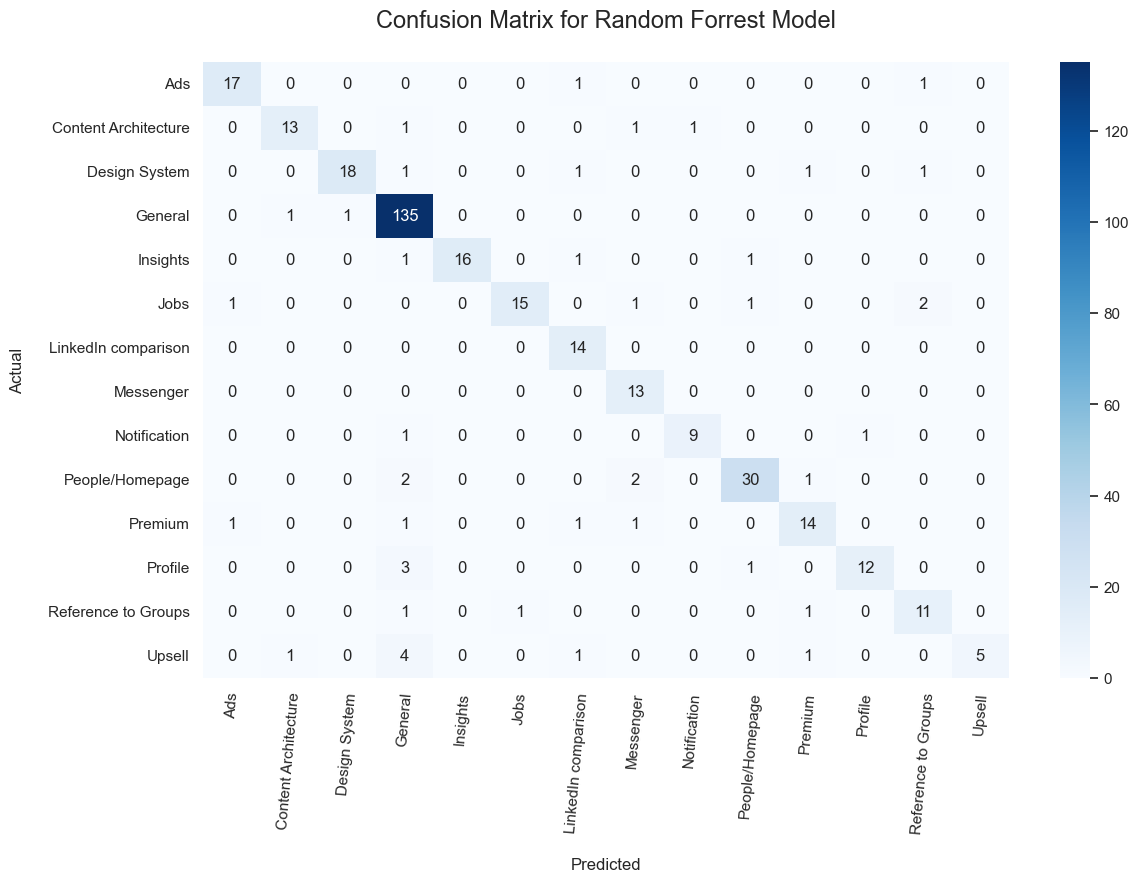

In [ ]:
sns.set(font_scale=1.0)
cm = confusion_matrix(y_test, grid_search.predict(X_test))
fig, ax = plt.subplots(figsize=(13,8))

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt='d',
            xticklabels = p_lr[-1].classes_,
            yticklabels = p_lr[-1].classes_,
            )

plt.ylabel('Actual\n')
plt.xlabel('\nPredicted')
plt.xticks(rotation = 85)
plt.title("Confusion Matrix for Random Forrest Model\n", size = 17)

In [ ]:
dump(grid_search, 'grid_search.joblib')

['grid_search.joblib']

In [ ]:
param_grid = {
    "Vectorizer_tfidf__max_features": [500, 1000, 1500, 2000, 2500],
    "Vectorizer_tfidf__ngram_range": [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
    "Vectorizer_tfidf__stop_words": [None, 'english'],
    "Vectorizer_tfidf__norm": ['l1', 'l2', None],
    "Vectorizer_tfidf__use_idf": [True, False],
    "Vectorizer_tfidf__smooth_idf": [True, False],
    "Vectorizer_tfidf__sublinear_tf": [True, False],   
    "Random Forest__n_estimators": [50, 100, 200, 300, 400],
    "Random Forest__max_depth" : [None, 10, 20, 30, 40, 50],
    "Random Forest__min_samples_split": [2, 5, 10],
    "Random Forest__min_samples_leaf": [1, 2, 4],
    "Random Forest__bootstrap": [True, False],
    "Random Forest__max_features": ['auto', 'sqrt', 'log2', None],
    "Random Forest__criterion": ["gini", "entropy"],
    "Random Forest__class_weight": [None, "balanced", "balanced_subsample"],
}

In [ ]:
# Initialize Random Search
random_search = RandomizedSearchCV(pipe_rnf, param_grid, cv=5, verbose=0, n_jobs=-1)
random_search.fit(X_train, y_train)asdfs

/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/suhas.kamuni/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 427, in

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Vectorizer_tfidf',
                                              TfidfVectorizer(max_features=500)),
                                             ('Random Forest',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_jobs=-1,
                   param_distributions={'Random Forest__bootstrap': [True,
                                                                     False],
                                        'Random Forest__class_weight': [None,
                                                                        'balanced',
                                                                        'balanced_subsample'],
                                        'Random Forest__criterion': ['gini',
                                                                     'entro...
                                                                        400],
                                        'Vectorizer_tfidf__max_features': [500,
                                                                           1000,
                                                                           1500,
                                                                           2000,
                                                                           2500],
                                        'Vectorizer_tfidf__ngram_range': [(1,
                                                                           1),
                                                                          (1,
                                                                           2),
                                                                          (1,
                                                                           3),
                                                                          (2,
                                                                           2),
                                                                          (2,
                                                                           3)],
                                        'Vectorizer_tfidf__norm': ['l1', 'l2',
                                                                   None],
                                        'Vectorizer_tfidf__smooth_idf': [True,
                                                                         False],
                                        'Vectorizer_tfidf__stop_words': [None,
                                                                         'english'],
                                        'Vectorizer_tfidf__sublinear_tf': [True,
                                                                           False],
                                        'Vectorizer_tfidf__use_idf': [True,
                                                                      False]})

In [ ]:
pipe_try(X_test, y_test, random_search)

	 	 		 	------------------
	 	 	 	 	F1 Score:  78.038 %
	 	 		 	Accuracy:  84.699 %
    	 	 	 	       Hamming Loss:  0.153
    	 	 	 	   Weighted F1 Score:  83.336 %
    	 	 	 	   ---------------------------


In [ ]:
print(metrics.classification_report(y_test, random_search.predict(X_test)))

                      precision    recall  f1-score   support

                 Ads       0.89      0.89      0.89        19
Content Architecture       0.92      0.75      0.83        16
       Design System       1.00      0.68      0.81        22
             General       0.85      0.99      0.92       137
            Insights       1.00      0.74      0.85        19
                Jobs       0.79      0.75      0.77        20
 LinkedIn comparison       0.82      1.00      0.90        14
           Messenger       0.86      0.92      0.89        13
        Notification       1.00      0.73      0.84        11
     People/Homepage       0.74      0.91      0.82        35
             Premium       0.72      0.72      0.72        18
             Profile       1.00      0.62      0.77        16
 Reference to Groups       0.73      0.79      0.76        14
              Upsell       1.00      0.08      0.15        12

            accuracy                           0.85       366
      

Text(0.5, 1.0, 'Confusion Matrix\n')

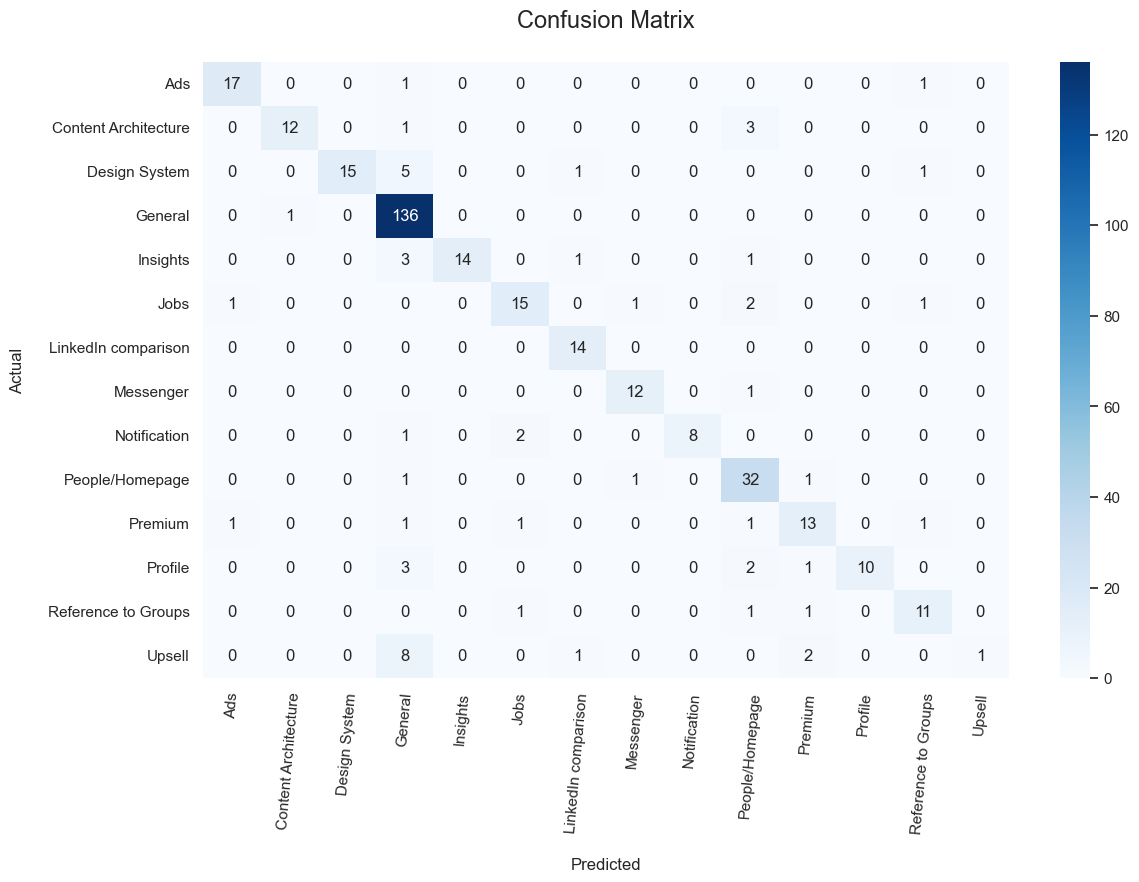

In [ ]:
sns.set(font_scale=1.0)
cm = confusion_matrix(y_test, random_search.predict(X_test))
fig, ax = plt.subplots(figsize=(13,8))

sns.heatmap(cm, 
            annot=True, 
            cmap="Blues", 
            fmt='d',
            xticklabels = p_lr[-1].classes_,
            yticklabels = p_lr[-1].classes_,
            )

plt.ylabel('Actual\n')
plt.xlabel('\nPredicted')
plt.xticks(rotation = 85)
plt.title("Confusion Matrix\n", size = 17)

# Results

In [ ]:
df['Predicted Team'] = p.predict(clean_text(df['Converted English']))
np.array(df[['Converted English', 'Predicted Team']])[:5]

NameError: name 'p' is not defined

In [ ]:
df['Predicted Team'].value_counts()

Predicted Team
General                 22
Ads                      8
People/Homepage          7
Messenger                4
Jobs                     4
Premium                  3
LinkedIn comparison      3
Notification             2
Design System            2
Content Architecture     2
Upsell                   1
Profile                  1
Reference to Groups      1
Name: count, dtype: int64

In [ ]:
df.loc[df['Predicted Team'] == 'General'][:5]

,Review_id,date,name,title,version,Reviews Content,rating,Platform,Converted English,Source/API,Week,Month,MemberId,Predicted Team,Probability Scores
4,269f5680-5989-4de5-9cb0-ebd2236e1121,2024-01-16,NaN,NaN,24.0.1m,Leider sehe ich kaum noch nutzen in der App.,3.0,Android,"Unfortunately, I see hardly any use in the app...",Data.AI,3,January,NaN,General,29.97%
5,24a1a063-1418-4d30-8da8-6d11ca1175b5,2024-01-15,NaN,NaN,24.0.1m,Bringt nicht viel App. Selbst bei Kleinigkeite...,1.0,Android,Don't bring a lot of app. Even small things re...,Data.AI,3,January,NaN,General,25.93%
6,fb912003-b8c6-4735-bfe5-136a52baad71,2024-01-15,NaN,NaN,24.0.1m,EMPFEHLUNG. .....( +15/100),3.0,Android,RECOMMENDATION.....( +15/100),Data.AI,3,January,NaN,General,27.49%
7,a62be798-3e3a-4586-880e-bf003d807dad,2024-01-08,NaN,NaN,24.0.1m,It's ask money.. it's giving random cities wit...,1.0,Android,It's ask money.. it's giving random cities wit...,Data.AI,2,January,NaN,General,29.32%
9,1d87f9b3-2a50-4141-9317-a1867a164e56,2024-01-06,NaN,NaN,24.0.1m,Etwas unverständlicherweise funktioniert das Ä...,2.0,Android,"Incomprehensiblely, changing your resume doesn...",Data.AI,1,January,NaN,General,33.12%


In [ ]:
prob_values = train_classifier(X_train, y_train, LR_502).predict_proba(X_test)
prob_values.shape

(366, 14)

In [ ]:
# Calculate value counts
value_counts = pd.Series(train_df['Predicted Team']).value_counts().sort_index().reset_index()

# Rename columns
value_counts.columns = ['Label', 'Count']

# Add corresponding number column
value_counts['Label Number'] = value_counts.index

# Print the result
print(value_counts)

                   Label  Count  Label Number
0                    Ads     94             0
1   Content Architecture     82             1
2          Design System    109             2
3                General    684             3
4               Insights     93             4
5                   Jobs    100             5
6    LinkedIn comparison     68             6
7              Messenger     64             7
8           Notification     57             8
9        People/Homepage    177             9
10               Premium     92            10
11               Profile     78            11
12   Reference to Groups     71            12
13                Upsell     59            13


In [ ]:
#(df['Team_Prob'].str.replace("[%]", " ").astype("float") > 30.00).value_counts()
#np.array(df.loc[df.Team_Prob > '50.00%'][['Converted English','Team_Prob']])
df['Predicted Team'].value_counts(normalize = True).mul(100).round(2).astype(str) + '%'

Predicted Team
General                 36.67%
Ads                     13.33%
People/Homepage         11.67%
Messenger                6.67%
Jobs                     6.67%
Premium                   5.0%
LinkedIn comparison       5.0%
Notification             3.33%
Design System            3.33%
Content Architecture     3.33%
Upsell                   1.67%
Profile                  1.67%
Reference to Groups      1.67%
Name: proportion, dtype: object

In [ ]:
df.groupby('Platform')['Source/API'].value_counts(normalize = True).mul(100).round(2).astype(str) + '%'

Platform  Source/API  
Android   Data.AI         56.52%
          EasyFeedback    43.48%
iOS       EasyFeedback    56.76%
          Data.AI         43.24%
Name: proportion, dtype: object

In [ ]:
#np.array(pipe.predict_proba(X_val) * 100)[:10]

# Visuals

Text(0, 0.5, '')

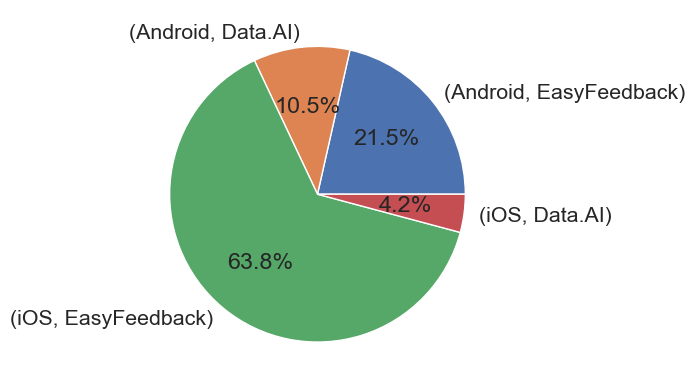

In [ ]:
sns.set(font_scale=1.4)
train_df.groupby('Platform')['Source'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')
#plt.figure(figsize = (10, 10))
plt.ylabel("")
#plt.title("Composition pie chart for Source and Platform of the reviews")

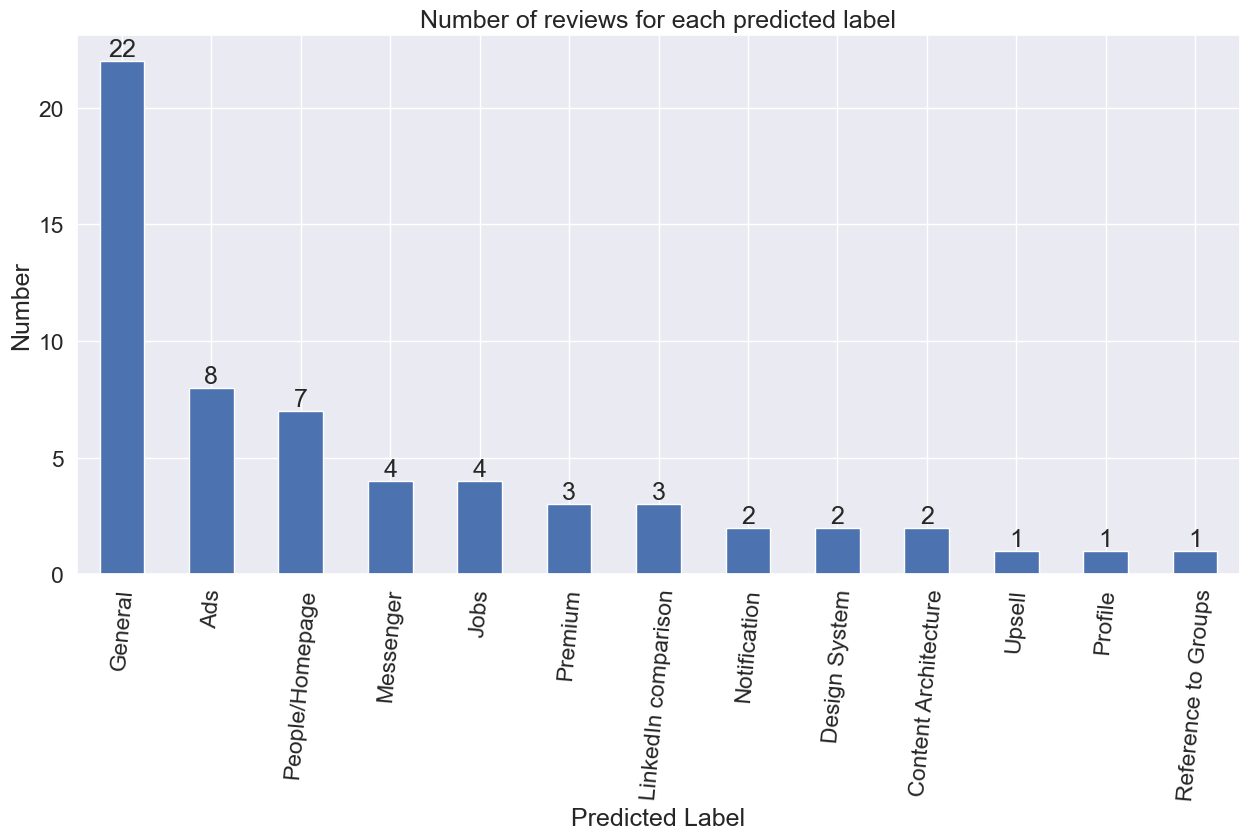

In [ ]:
plt.figure(figsize=(15, 7))
sns.set(font_scale=1.5)

# Get value counts for each category
counts = df['Predicted Team'].value_counts()

# Plot the counts as a bar chart
#ax = counts.plot(kind='line', marker='*', color='black', ms=10)
ax = counts.plot(kind='bar')

# Set the x-axis label and title
ax.set_xlabel('Category')
ax.set_title('Category Counts')

# Add count values as annotations
for i, v in enumerate(counts):
    ax.text(i, v, str(v), ha = 'center', va='bottom')

# Show the plot
plt.ylabel("Number")
plt.xticks(rotation = 85)
plt.title("Number of reviews for each predicted label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
train_df.groupby(['Platform'])['Rating'].value_counts().sort_index()

Platform  Rating
Android   1         189
          2         250
          3          67
          4          45
          5          41
iOS       1         303
          2         642
          3         186
          4          95
          5          31
Name: count, dtype: int64

Text(0.5, 0, 'Rating')

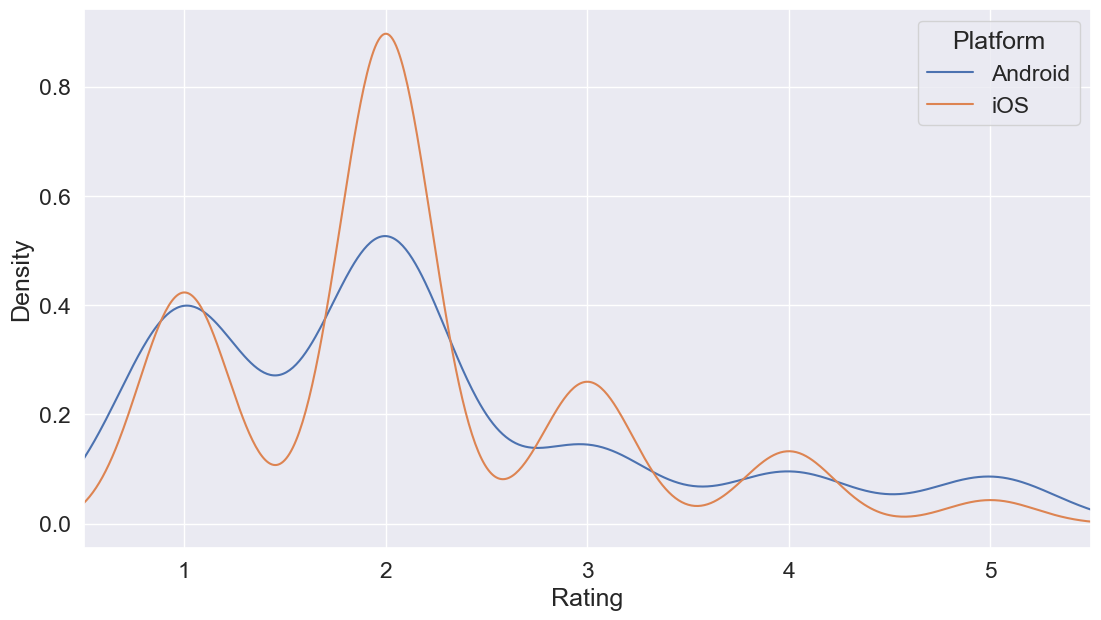

In [ ]:
plt.figure(figsize=(13, 7))
sns.set(font_scale=1.5)
train_df.groupby('Platform')['Rating'].plot(kind='kde')
plt.xlim(0.5,5.5)
plt.legend(['Android', 'iOS'], title='Platform')
#plt.title("Difference in the ratings selected by users in each platform")
plt.xlabel("Rating")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Ads'),
  Text(1, 0, 'CPAY'),
  Text(2, 0, 'Content Architecture'),
  Text(3, 0, 'Design System'),
  Text(4, 0, 'General'),
  Text(5, 0, 'Insights'),
  Text(6, 0, 'Jobs'),
  Text(7, 0, 'LinkedIn comparison'),
  Text(8, 0, 'Messenger'),
  Text(9, 0, 'Notification'),
  Text(10, 0, 'People/Homepage'),
  Text(11, 0, 'Premium'),
  Text(12, 0, 'Profile'),
  Text(13, 0, 'Reference to Groups'),
  Text(14, 0, 'Upsell')])

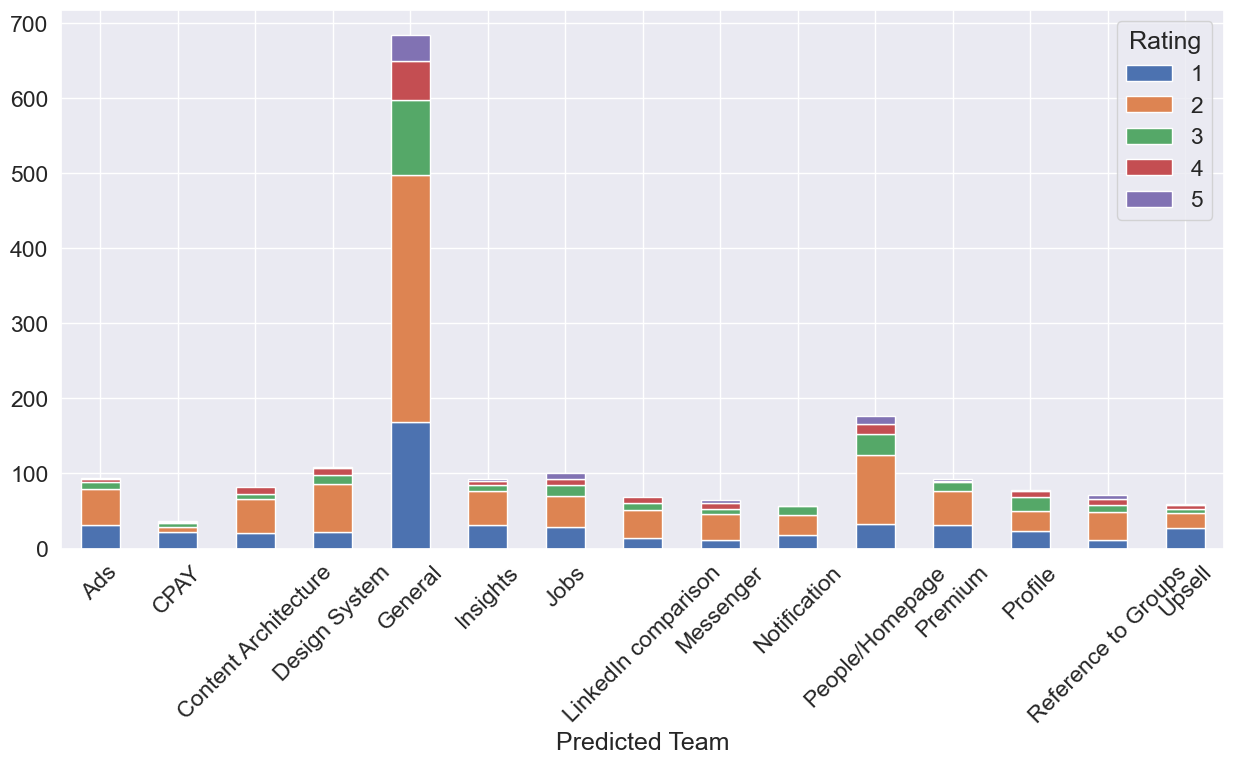

In [ ]:
train_df.groupby("Predicted Team", sort = True)['Rating'].value_counts().unstack().plot.bar(stacked = True, figsize = (15, 7))
plt.xticks(rotation = 45)

In [ ]:
df.groupby("Predicted Team", sort = True)['Rating'].value_counts().unstack()

Rating,1,2,3,4,5
Predicted Team,,,,,
Ads,1.0,NaN,1.0,NaN,NaN
Content Architecture,NaN,1.0,NaN,NaN,NaN
Design System,NaN,NaN,NaN,1.0,NaN
General,5.0,11.0,3.0,4.0,2.0
Insights,1.0,1.0,NaN,NaN,NaN
Jobs,5.0,6.0,NaN,NaN,NaN
LinkedIn comparison,NaN,1.0,NaN,NaN,NaN
Messenger,1.0,3.0,2.0,NaN,NaN
Notification,1.0,1.0,NaN,NaN,NaN


In [ ]:
# df.to_excel(path, index=False)